# Сборка датасета COCO для обучения модели детекции нарушений СИЗ

Датасет: [Construction Site Safety Image Dataset Roboflow](https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow)

## Imports

In [8]:
%load_ext autoreload
%autoreload 2

In [1]:
from pathlib import Path
import shutil
import os

from pydantic import BaseModel
from datumaro.components.dataset import Dataset, AnnotationType
import matplotlib.pyplot as plt

from ppe_modelling.logger import logger
from ppe_modelling.utils import write_string_to_file, system_info_banner

## System info

In [2]:
logger.info(system_info_banner())

/home/quakumei/.pyenv/versions/3.10.12/lib/python3.10/importlib/util.py:247: DeprecationWarning: The `openvino.runtime` module is deprecated and will be removed in the 2026.0 release. Please replace `openvino.runtime` with `openvino`.
  self.__spec__.loader.exec_module(self)
[ppe-modelling] 06.04.2025 14:46:58 === System Information ===
System: Linux
Machine: x86_64
OS Version: #59~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Mar 19 17:07:41 UTC 2
OS Name: Linux-6.8.0-57-generic-x86_64-with-glibc2.35

=== Hardware Information ===
RAM: 62.64 GB
CPU: x86_64 (20 cores)
GPU: NVIDIA GeForce RTX 3090
nvcc: nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:18:24_PDT_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0

=== Libraries Information ===
torch: 2.6; cuda: cu124
detectron2: 0.6


## Settings

In [3]:
class PPEDatasetBuildSettings(BaseModel):
    data_root: Path = Path('../data/')
    classes: dict = {0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest', 5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'machinery', 9: 'vehicle'}
    coco_dataset_path: Path = Path('../data/construction-site-safety-image-dataset-roboflow-coco-apr-6')

ds_settings = PPEDatasetBuildSettings()

## Dataset

### Fetch

In [4]:
ds_zip_path = ds_settings.data_root / 'construction-site-safety-image-dataset-roboflow.zip'
if not ds_zip_path.exists():
    !curl -L -o $ds_zip_path https://www.kaggle.com/api/v1/datasets/download/snehilsanyal/construction-site-safety-image-dataset-roboflow
    print("Download done!")

ds_unzip_path = ds_settings.data_root / 'construction-site-safety-image-dataset-roboflow'
if not ds_unzip_path.exists():
    !unzip $ds_zip_path -d $ds_unzip_path
    print("Unzip done!")

### Import to Datumaro

In [5]:
def fix_yolo_ds(data_path: Path):
    yaml_path = data_path / 'data.yaml'
    if not yaml_path.exists():
        class_names_lines = [
            f"  {i}: {class_name}" for i, class_name in ds_settings.classes.items()
        ]
        yaml_contents = [
            "path: .",
            "test: test.txt",
            "train: train.txt",
            "val: val.txt",
            "names:",
            *class_names_lines
        ]
        yaml_str = "\n".join(yaml_contents)
        logger.info(yaml_str)
        write_string_to_file(yaml_path, yaml_str)

    images_path = data_path / 'images'
    if not images_path.exists():
        images_path.mkdir()
        shutil.move(data_path / 'test' / 'images', data_path / 'images' / 'test')
        shutil.move(data_path / 'train' / 'images', data_path / 'images' / 'train')
        shutil.move(data_path / 'valid' / 'images', data_path / 'images' / 'val')

    labels_path = data_path / 'labels'
    if not labels_path.exists():
        labels_path.mkdir()
        shutil.move(data_path / 'test' / 'labels', labels_path / 'test')
        shutil.move(data_path / 'train' / 'labels', labels_path / 'train')
        shutil.move(data_path / 'valid' / 'labels', labels_path / 'val')

    subsets = ['train','test','val']
    for subset in subsets:
        subset_file_path = data_path / f'{subset}.txt'
        if not subset_file_path.exists():
            subset_dir = data_path / 'images' / subset
            subset_files = os.listdir(subset_dir)
            subset_file_lines = [os.path.join('./images', f'{subset}', f) for f in subset_files]
            assert subset_file_lines[0].startswith('./images'), subset_file_lines[0].startswith('./images')
            subset_file_str = "\n".join(subset_file_lines)
            write_string_to_file(subset_file_path, subset_file_str)

data_path = ds_unzip_path / 'css-data'
fix_yolo_ds(data_path)



In [6]:
logger.info(Path(data_path).exists())
ppe_dataset = Dataset.import_from(data_path, "yolo")
ppe_dataset

[ppe-modelling] 06.04.2025 14:46:58 True


Dataset
	size=2801
	source_path=../data/construction-site-safety-image-dataset-roboflow/css-data
	media_type=<class 'datumaro.components.media.Image'>
	ann_types={<AnnotationType.bbox: 6>}
	annotated_items_count=2777
	annotations_count=38352
subsets
	test: # of items=82, # of annotated items=74, # of annotations=760
	train: # of items=2605, # of annotated items=2599, # of annotations=36895
	val: # of items=114, # of annotated items=104, # of annotations=697
infos
	categories
	label: ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']

### EDA

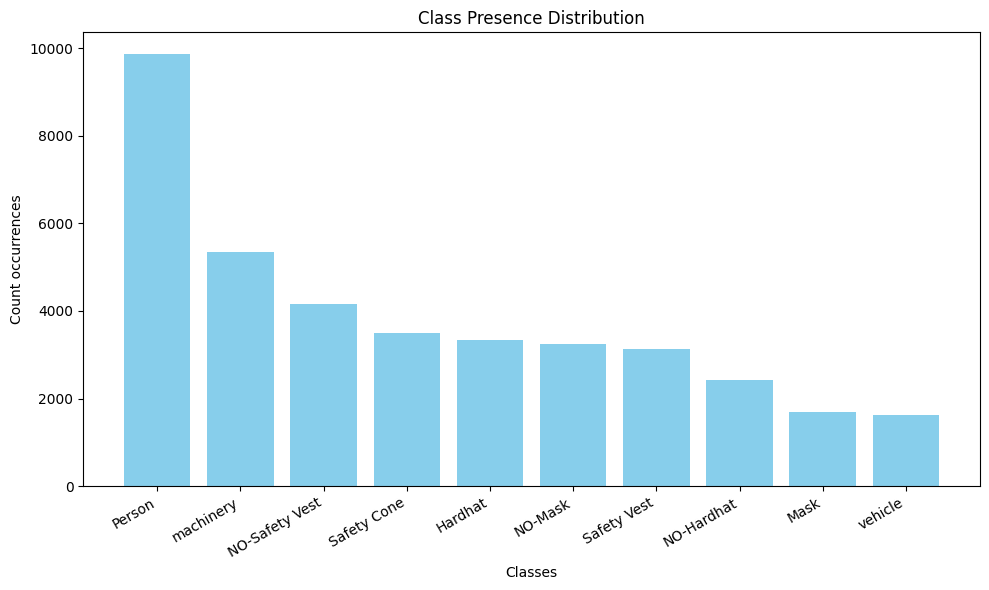

In [7]:
def calc_classes(ds: Dataset) -> dict:
    labels = ds.categories()[AnnotationType.label]._indices
    idx_to_label = {v:k for k, v in labels.items()}
    counts = {label_i: 0 for label, label_i in labels.items()}
    for item in ds:
        for ann in item.annotations:
            counts[ann.label] += 1
    return {idx_to_label[k]:v for k, v in counts.items()}

def visualize_class_presence_distribution(calced_classes: dict[str, int]) -> None:
    # Sort the dictionary items by value in descending order
    sorted_items = sorted(calced_classes.items(), key=lambda item: item[1], reverse=True)

    # Unzip the sorted items into labels and counts
    labels, counts = zip(*sorted_items)

    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Count occurrences')
    plt.title('Class Presence Distribution')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

classes_counts = calc_classes(ppe_dataset)
visualize_class_presence_distribution(classes_counts)

### Export to COCO Instances

In [16]:
def export_ds(ds: Dataset, path: Path | str):
    path = Path(path)
    format = "coco_instances"
    if path.exists():
        shutil.rmtree(path)
    ds.export(path, format, save_media=True, reindex=True)
    logger.info(f"Saved '{format}' dataset to {str(path)}")

export_ds(ppe_dataset, ds_settings.coco_dataset_path)

[ppe-modelling] 06.04.2025 14:50:19 Saved 'coco_instances' dataset to ../data/construction-site-safety-image-dataset-roboflow-coco-apr-6
